## Trabalho Final - Machine Learning
RM: 358770 - Erika Koyanagui

RM: 358488 - Fabio Asnis Campos da Silva

RM: 359283 - Lucas Huber Pissaia

RM: 358477 - Matheus Raeski

Neste trabalho, como parte do time de analistas da Quantum Finance, exploramos a base de dados originalmente utilizada para classificação de score de crédito, disponível no Kaggle (https://www.kaggle.com/datasets/parisrohan/credit-score-classification), utilizando técnicas de Análise Exploratória de Dados (EDA) e algoritmos de Machine Learning supervisionados.

A descrição de cada etapa e decisão encontram-se no decorrer do código. Nossas conclusões sobre o trabalho, qual é a métrica mais adequada assim como futuros passos, encontram-se na etapa final.

# Import & Config

In [34]:
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.types import NumericType, IntegerType, DoubleType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

import pandas as pd

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

import time

### Start Spark Session

In [35]:
spark = SparkSession.builder \
    .appName("Trabalho Final ML - PySpark") \
    .getOrCreate()

### Mount Drive

In [36]:
from google.colab import drive
# Montar o Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data source

In [39]:
# Leitura do CSV com PySpark
df_raw = spark.read.csv("/content/drive/MyDrive/train_score_ml.csv", header=True, inferSchema=True)
df_raw.printSchema()
df_raw.show(5)

df_test = spark.read.csv("/content/drive/MyDrive/test_score_ml.csv", header=True, inferSchema=True)
df_test.printSchema()
df_test.show(5)

root
 |-- ID: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SSN: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Annual_Income: string (nullable = true)
 |-- Monthly_Inhand_Salary: double (nullable = true)
 |-- Num_Bank_Accounts: integer (nullable = true)
 |-- Num_Credit_Card: integer (nullable = true)
 |-- Interest_Rate: integer (nullable = true)
 |-- Num_of_Loan: string (nullable = true)
 |-- Type_of_Loan: string (nullable = true)
 |-- Delay_from_due_date: integer (nullable = true)
 |-- Num_of_Delayed_Payment: string (nullable = true)
 |-- Changed_Credit_Limit: string (nullable = true)
 |-- Num_Credit_Inquiries: double (nullable = true)
 |-- Credit_Mix: string (nullable = true)
 |-- Outstanding_Debt: string (nullable = true)
 |-- Credit_Utilization_Ratio: double (nullable = true)
 |-- Credit_History_Age: string (nullable = true

### Columns Validation

In [40]:
df_raw.describe().show()

+-------+-------+-----------+------+------+------------------+-----------+----------+------------------+---------------------+-----------------+------------------+------------------+------------------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+------------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+--------------------+------------+
|summary|     ID|Customer_ID| Month|  Name|               Age|        SSN|Occupation|     Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|   Num_Credit_Card|     Interest_Rate|       Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|  Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|     Monthly_Balance|Cred

Quando olhamos para o resultado do .describe.show vemos aqui algumas oportunidades de tratamento.
Colunas como "Age" merecem atenção, variando de -500 a 995 com uma média e desvio padrão fora da realidade.
Não só ela, temos também colunas com "_" após ou antes o valor, desvios padrões e médias que indicam presença de outliers.

#Data Transform

Decidimos por eliminar colunas que não vão influenciar no modelo e estão apenas aumentando o número de dados, como "Name" e "SSN".
Aplicamos também substituições de valores que achamos válidas, retiramos o "_", limitando valores que estão de fato fora da realidade.

In [41]:
def data_transform(df):
    return (
        df
        .drop('Name', 'SSN')
        .withColumn('Occupation', when(col('Occupation') == '_______', 'N/A').otherwise(col('Occupation')))
        .withColumn('Monthly_Inhand_Salary', when(col('Monthly_Inhand_Salary').isNull(), col('Annual_Income')/12).otherwise(col('Monthly_Inhand_Salary')))
        .withColumn('Age', regexp_replace(col('Age'), '_', '').cast('int')) #
        .withColumn('Num_of_Loan', regexp_replace(col('Num_of_Loan'), '_', '').cast('int'))
        .withColumn('Monthly_Balance', regexp_replace(col('Monthly_Balance'), '_', '').cast('double'))
        .withColumn('Num_of_Delayed_Payment', regexp_replace(col('Num_of_Delayed_Payment'), '_', '').cast('int'))
        .withColumn('Changed_Credit_Limit', regexp_replace(col('Changed_Credit_Limit'), '_', '').cast('int'))
        .withColumn('Amount_invested_monthly', regexp_replace(col('Amount_invested_monthly'), '_', '').cast('double'))
        .withColumn('Credit_Mix', when(col('Credit_Mix') == '_', 'N/A').otherwise(col('Credit_Mix')))
        .withColumn('Payment_Behaviour', when(col('Payment_Behaviour') == '!@9#%8', 'N/A').otherwise(col('Payment_Behaviour')))
        .withColumn('Age', when((col('Age') > 100) | (col('Age') <= 0), None).otherwise(col('Age')).cast('int'))
    )

df_raw = data_transform(df_raw)
df_raw.show()

df_test = data_transform(df_test)
df_test.show()

+------+-----------+--------+----+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------+
|    ID|Customer_ID|   Month| Age|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+------+-----------+--------+----+----------+-------------+---------------------+-----------------+---------------+---

# Tratamento de coluna Credit_History_Age

Para podermos trabalhar com a coluna Credit_History_Age é necessário transformá-la em valores: usando uma fórmula simples de years * 12 + months

In [42]:
def convert_credit_history_age_to_months(df,
                                         source_col='Credit_History_Age',
                                         target_col='Credit_History_Age_Months'):
    """
    Recebe um DataFrame com coluna de string no formato
    'XX Years and YY Months' (ou 'NA'/NULL) e adiciona uma
    coluna com o total em meses (int).
    """
    # Extrai anos e meses via regex
    years =  regexp_extract(col(source_col), r'(\d+)\s+Years?', 1).cast('int')
    months = regexp_extract(col(source_col), r'(\d+)\s+Months?', 1).cast('int')

    return df.withColumn(
        target_col,
        when(
            col(source_col).isNull() | (col(source_col) == 'NA'),
            None
        ).otherwise(
            years * 12 + months
        )
    )

df_raw = convert_credit_history_age_to_months(df_raw)
df_raw = df_raw.drop('Credit_History_Age')

df_test = convert_credit_history_age_to_months(df_test)
df_test = df_test.drop('Credit_History_Age')

In [43]:
df_raw.describe().show()

+-------+-------+-----------+------+-----------------+----------+------------------+---------------------+-----------------+------------------+------------------+-----------------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+------------------+------------------------+---------------------+-------------------+-----------------------+--------------------+--------------------+------------+-------------------------+
|summary|     ID|Customer_ID| Month|              Age|Occupation|     Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|   Num_Credit_Card|     Interest_Rate|      Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|  Outstanding_Debt|Credit_Utilization_Ratio|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|     Monthly_Balance|Credit_Score|Credit_History_Age_Months|
+-------+-------+-----

# Análise para One-hot encoding

Pensando em colunas com strings, valores categóricos, temos sempre algumas opções para o modelo: não usá-las, dar peso para os valores, transformar em número ou fazer hot encoding.
Aqui decidimos por fazr one-hot encoding para colunas que possuem até 10 valores distintos e uma simples substituição para colunas que tenham mais de 10 valores únicos (devido ao maior pedido de processamento que colunas assim teriam ao passar por OHE).
Fizemos a contagem da variável target abaixo não para aplicar o OHE, mas para já entender um pouco mais se estamos trabalhando com um resultado balanceado ou não.

In [44]:
# Vamos analisar as colunas String para determinar se faremos o OHE

def show_full_value_counts_and_distinct(df, cols):
    """
    Para cada coluna em `cols`, exibe:
      1) o número total de valores distintos
      2) a lista completa de valores distintos com suas contagens
    """
    for c in cols:
        # 1) conta quantos valores distintos existem
        distinct_count = df.select(c).distinct().count()
        print(f"\n===== {c} (distinct: {distinct_count}) =====")
        # 2) agrupa, conta e ordena, mostrando todos os valores
        df.groupBy(c) \
          .count() \
          .orderBy(desc("count")) \
          .show(n=20, truncate=False)

#Colunas para análise
cols_to_count = [
    "Type_of_Loan",
    "Credit_Mix",
    "Payment_of_Min_Amount",
    "Payment_Behaviour",
    "Credit_Score",
    "Month",
    "Occupation"
]

show_full_value_counts_and_distinct(df_raw, cols_to_count)


===== Type_of_Loan (distinct: 6261) =====
+----------------------------------------+-----+
|Type_of_Loan                            |count|
+----------------------------------------+-----+
|NULL                                    |11408|
|Not Specified                           |1408 |
|Credit-Builder Loan                     |1280 |
|Personal Loan                           |1272 |
|Debt Consolidation Loan                 |1264 |
|Student Loan                            |1240 |
|Payday Loan                             |1200 |
|Mortgage Loan                           |1176 |
|Auto Loan                               |1152 |
|Home Equity Loan                        |1136 |
|Personal Loan, and Student Loan         |320  |
|Not Specified, and Payday Loan          |272  |
|Mortgage Loan, and Home Equity Loan     |264  |
|Student Loan, and Payday Loan           |256  |
|Student Loan, and Credit-Builder Loan   |248  |
|Credit-Builder Loan, and Not Specified  |248  |
|Payday Loan, and Auto Loa

# Executando o One-hot encoding

In [45]:
# Vamos utilziar o OHE para as colunas que possuem valores distintos <=10
# Credit_Mix, Payment_of_Min_Amount, Payment_Behaviour, Month
onehot_cols = ["Credit_Mix", "Payment_of_Min_Amount", "Payment_Behaviour", "Month"]
index_only = ["Occupation", "Type_of_Loan"]

def one_hot_encode_columns(df, index_cols, ohe_cols, handle_invalid="keep", drop_last=False):
    """
    Aplica StringIndexer em `index_cols` e StringIndexer+OneHotEncoder em `ohe_cols`.

    Parâmetros:
    - df: DataFrame de entrada
    - index_cols: lista de colunas para aplicar apenas StringIndexer → <col>_idx
    - ohe_cols:   lista de colunas para aplicar StringIndexer → <col>_idx e OneHotEncoder → <col>_ohe

    Retorna:
    - DataFrame com todas as colunas indexadas e vetores OHE para as colunas de ohe_cols;
      índices intermediários de ohe_cols são removidos no final.
    """
    stages = []

    # índices simples
    for c in index_cols:
        stages.append(
            StringIndexer(
                inputCol=c,
                outputCol=f"{c}_idx",
                handleInvalid=handle_invalid
            )
        )

    # índice + one-hot
    for c in ohe_cols:
        idx_col = f"{c}_idx"
        ohe_col = f"{c}_ohe"
        stages += [
            StringIndexer(
                inputCol=c,
                outputCol=idx_col,
                handleInvalid=handle_invalid
            ),
            OneHotEncoder(
                inputCol=idx_col,
                outputCol=ohe_col,
                dropLast=drop_last
            )
        ]

    if not stages:
        return df  # nada a fazer

    model    = Pipeline(stages=stages).fit(df)
    df_trans = model.transform(df)

    # remove apenas os índices intermediários das colunas OHE
    idxs_to_drop = [f"{c}_idx" for c in ohe_cols]
    return df_trans.drop(*idxs_to_drop)

# Executando o OHE nas colunas selecionadas
df_raw = one_hot_encode_columns(df_raw, index_only, onehot_cols).drop(*index_only).drop(*onehot_cols)
df_raw.select(*[f"{c}_idx" for c in index_only], *[f"{c}_ohe" for c in onehot_cols]).show(truncate=False)
df_raw.printSchema()

df_test = one_hot_encode_columns(df_test, index_only, onehot_cols).drop(*index_only).drop(*onehot_cols)
df_test.printSchema()
# df_raw = one_hot_encode_columns(df_raw, cols_to_encode)
# df_raw.select(*[f"{c}_ohe" for c in cols_to_encode]).show(truncate=False)

+--------------+----------------+--------------+-------------------------+---------------------+-------------+
|Occupation_idx|Type_of_Loan_idx|Credit_Mix_ohe|Payment_of_Min_Amount_ohe|Payment_Behaviour_ohe|Month_ohe    |
+--------------+----------------+--------------+-------------------------+---------------------+-------------+
|4.0           |995.0           |(5,[2],[1.0]) |(4,[1],[1.0])            |(8,[4],[1.0])        |(9,[3],[1.0])|
|4.0           |995.0           |(5,[1],[1.0]) |(4,[1],[1.0])            |(8,[5],[1.0])        |(9,[2],[1.0])|
|4.0           |995.0           |(5,[1],[1.0]) |(4,[1],[1.0])            |(8,[2],[1.0])        |(9,[6],[1.0])|
|4.0           |995.0           |(5,[1],[1.0]) |(4,[1],[1.0])            |(8,[0],[1.0])        |(9,[0],[1.0])|
|4.0           |995.0           |(5,[1],[1.0]) |(4,[1],[1.0])            |(8,[1],[1.0])        |(9,[7],[1.0])|
|4.0           |995.0           |(5,[1],[1.0]) |(4,[1],[1.0])            |(8,[6],[1.0])        |(9,[5],[1.0])|
|

# Winsorizando as colunas

Para colunas numércias, sempre é de bom grado olhar para valores outliers.
Ao olhar para valores como mínimo, máximo, média e desvio padrão, podemos ver que várias colunas possuem outliers. Diferente do campo "Age" em que tínhamos valores visivelmente errados (como -500 ou 150), as colunas abaixo aparentam possuir valores reais porém com outliers.

Para trabalhá-los, podemos eliminar esses valores (correndo o risco de diminuir o tamanho da amostra), substituir por média/moda/mediana ou até pelos limites inferior e superior.

Essa técnica, de substituir pelos limites, foi a escolha para ser aplicada.

In [46]:
# Não aplicamos winsorização em colunas *_idx e *_ohe pois elas são codificações de categorias (índices ou vetores), não variáveis numéricas contínuas.
# Capar esses valores distorce a semântica das classes e invalida o significado das categorias no modelo.

numeric_columns_df = [
  'Annual_Income',
  'Num_Credit_Card',
  'Num_Bank_Accounts',
  'Interest_Rate',
  'Num_of_Loan',
  'Delay_from_due_date',
  'Num_of_Delayed_Payment',
  'Changed_Credit_Limit',
  'Num_Credit_Inquiries',
  'Outstanding_Debt',
  'Total_EMI_per_month',
  'Amount_invested_monthly',
  'Monthly_Balance',
  'Credit_History_Age_Months',
  'Credit_Utilization_Ratio',
]

def winsorize_columns(df, columns):
    for col_name in columns:
        # 1. Tenta fazer cast direto pra Double (sem remover ponto ou sinal negativo)
        df = df.withColumn(col_name, col(col_name).cast(DoubleType()))

        # 2. Calcular quartis
        quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
        if len(quantiles) < 2:
            print(f"⚠️ Pulando coluna {col_name}: não foi possível calcular quartis.")
            continue

        q1, q3 = quantiles
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # 3. Winsorização
        df = df.withColumn(
            col_name,
            when(col(col_name) < lower_bound, lower_bound)
            .when(col(col_name) > upper_bound, upper_bound)
            .otherwise(col(col_name))
        )

    return df

df_raw = winsorize_columns(df_raw, numeric_columns_df)
df_raw.describe().show()

df_test = winsorize_columns(df_test, numeric_columns_df)
df_test.describe().show()


+-------+-------+-----------+-----------------+------------------+---------------------+-----------------+-----------------+-----------------+-----------------+-------------------+----------------------+--------------------+--------------------+------------------+------------------------+-------------------+-----------------------+-------------------+------------+-------------------------+------------------+------------------+
|summary|     ID|Customer_ID|              Age|     Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|  Num_Credit_Card|    Interest_Rate|      Num_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|  Outstanding_Debt|Credit_Utilization_Ratio|Total_EMI_per_month|Amount_invested_monthly|    Monthly_Balance|Credit_Score|Credit_History_Age_Months|    Occupation_idx|  Type_of_Loan_idx|
+-------+-------+-----------+-----------------+------------------+---------------------+-----------------+-----------------+--------------

# Geração de matriz de correlação

In [47]:
from pyspark.sql.functions import col

numeric_cols = [
  'Annual_Income', 'Num_Credit_Card', 'Num_Bank_Accounts',
  'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
  'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
  'Outstanding_Debt', 'Total_EMI_per_month', 'Amount_invested_monthly',
  'Monthly_Balance', 'Credit_History_Age_Months', 'Credit_Utilization_Ratio'
]

# Criar matriz de correlação
correlation_matrix = {}

for i in numeric_cols:
    correlation_matrix[i] = {}
    for j in numeric_cols:
        corr = df_raw.stat.corr(i, j)
        correlation_matrix[i][j] = corr

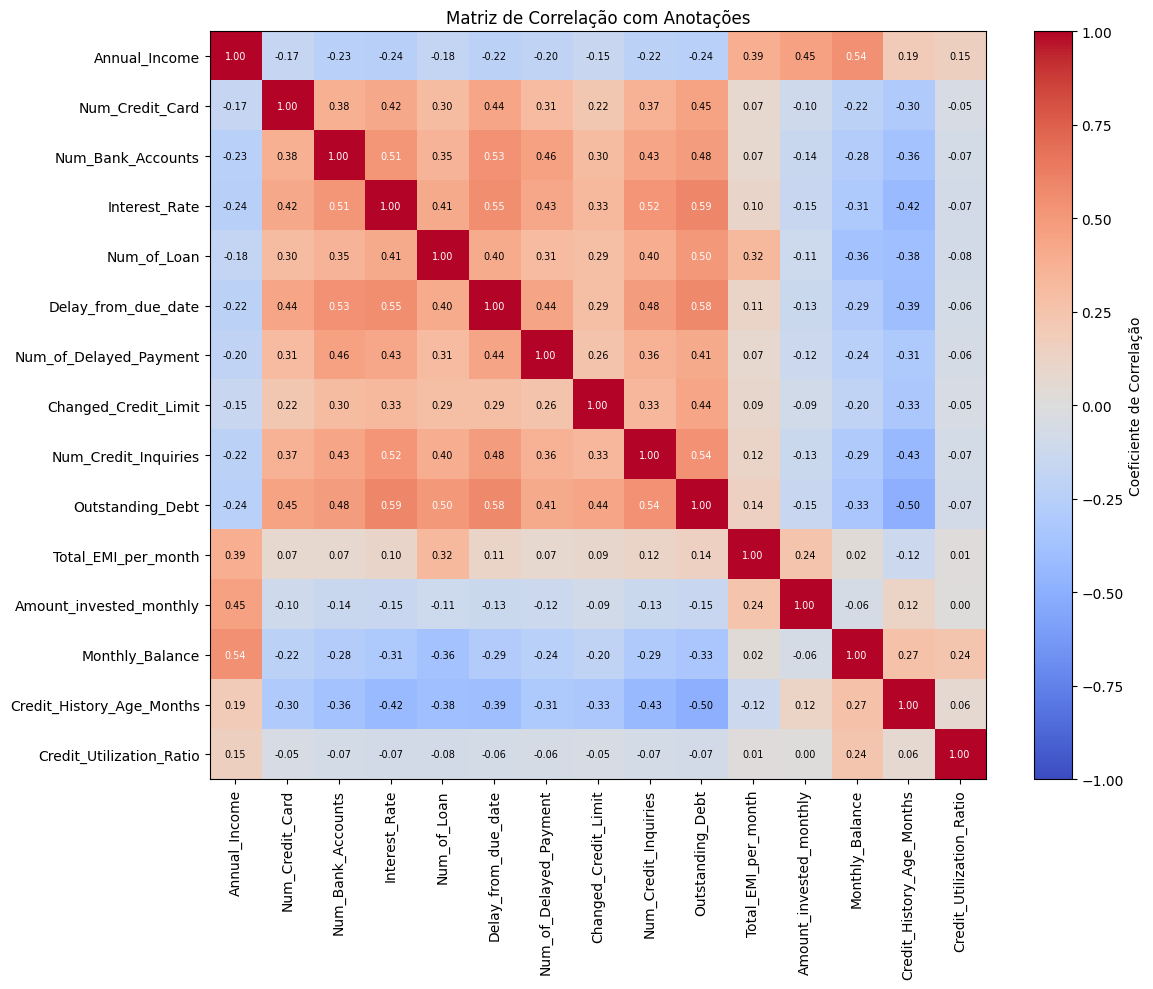

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import builtins  # garante que usaremos o abs do Python

# Se você tiver um Spark DataFrame, converta antes:
# corr_df = spark_corr_df.toPandas()
# Caso já esteja com dict → pandas, basta:
corr_df = pd.DataFrame(correlation_matrix)

plt.figure(figsize=(12, 10))
im = plt.imshow(corr_df.values, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, label='Coeficiente de Correlação')
plt.xticks(range(len(corr_df.columns)), corr_df.columns, rotation=90)
plt.yticks(range(len(corr_df.index)), corr_df.index)

for i in range(len(corr_df.index)):
    for j in range(len(corr_df.columns)):
        # 1) extrai o valor como Python float
        val = float(corr_df.iat[i, j])
        # 2) calcula a cor com o abs do Python (builtins.abs)
        txt_color = 'black' if builtins.abs(val) < 0.5 else 'white'
        plt.text(
            j, i,
            f"{val:.2f}",
            ha='center', va='center',
            fontsize=7,
            color=txt_color
        )

plt.title('Matriz de Correlação com Anotações')
plt.tight_layout()
plt.show()


Após analisar a matriz de correlação das features, descartamos as colunas com alta redundância estatística (|ρ|>0.5) para evitar multicolinearidade e simplificar o modelo.
Com isso, mantemos apenas variáveis âncora que carregam informação única e relevante para a previsão.

In [49]:
# 1) Liste as colunas redundantes que queremos remover
cols_to_drop = [
    'Outstanding_Debt',
    'Delay_from_due_date',
    'Num_of_Delayed_Payment',
    'Monthly_Balance'
]

# 2) Copie df_raw para df_features e drope as colunas
df_raw = df_raw.drop(*cols_to_drop)
df_test = df_test.drop(*cols_to_drop)

# 3) (Opcional) Confira o schema para ver se as colunas foram removidas
df_raw.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Annual_Income: double (nullable = true)
 |-- Monthly_Inhand_Salary: double (nullable = true)
 |-- Num_Bank_Accounts: double (nullable = true)
 |-- Num_Credit_Card: double (nullable = true)
 |-- Interest_Rate: double (nullable = true)
 |-- Num_of_Loan: double (nullable = true)
 |-- Changed_Credit_Limit: double (nullable = true)
 |-- Num_Credit_Inquiries: double (nullable = true)
 |-- Credit_Utilization_Ratio: double (nullable = true)
 |-- Total_EMI_per_month: double (nullable = true)
 |-- Amount_invested_monthly: double (nullable = true)
 |-- Credit_Score: string (nullable = true)
 |-- Credit_History_Age_Months: double (nullable = true)
 |-- Occupation_idx: double (nullable = false)
 |-- Type_of_Loan_idx: double (nullable = false)
 |-- Credit_Mix_ohe: vector (nullable = true)
 |-- Payment_of_Min_Amount_ohe: vector (nullable = true)
 |-- Payment_Behaviour_ohe: vector

In [50]:
df_test.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Annual_Income: double (nullable = true)
 |-- Monthly_Inhand_Salary: double (nullable = true)
 |-- Num_Bank_Accounts: double (nullable = true)
 |-- Num_Credit_Card: double (nullable = true)
 |-- Interest_Rate: double (nullable = true)
 |-- Num_of_Loan: double (nullable = true)
 |-- Changed_Credit_Limit: double (nullable = true)
 |-- Num_Credit_Inquiries: double (nullable = true)
 |-- Credit_Utilization_Ratio: double (nullable = true)
 |-- Total_EMI_per_month: double (nullable = true)
 |-- Amount_invested_monthly: double (nullable = true)
 |-- Credit_History_Age_Months: double (nullable = true)
 |-- Occupation_idx: double (nullable = false)
 |-- Type_of_Loan_idx: double (nullable = false)
 |-- Credit_Mix_ohe: vector (nullable = true)
 |-- Payment_of_Min_Amount_ohe: vector (nullable = true)
 |-- Payment_Behaviour_ohe: vector (nullable = true)
 |-- Month_ohe: vector (n

# Machine Learning


Agora, após fazer uma análise exploratória dos dados e transformá-los conforme necessidade, podemos ir para os modelos de classificação.
Vamos trabalhar com três: RandomForest, XGBoost, LightGBM

In [51]:
# 1. Converte de Spark para Pandas
df_pd = df_raw.toPandas()
df_pd_test = df_test.toPandas()

# 2. Trata strings que viram NaN no Pandas
for df in [df_pd, df_pd_test]:
    df.replace(["N/A", "NM", "na", "NaN", "-", ""], pd.NA, inplace=True)

# 3. Converte colunas para números (menos ID e target)
for col in df_pd.columns:
    if col not in ["ID", "Customer_ID", "Month", "Credit_Score"]:
        df_pd[col] = pd.to_numeric(df_pd[col], errors='coerce')
        if col in df_pd_test.columns:
            df_pd_test[col] = pd.to_numeric(df_pd_test[col], errors='coerce')

# 4. Remove nulos no target e preenche o resto com zero
df_pd = df_pd.dropna(subset=["Credit_Score"])
# Fill numerical columns with 0, leave 'Credit_Score' as is for encoding
numerical_cols_to_fill = df_pd.select_dtypes(include=["number"]).columns.tolist()
df_pd[numerical_cols_to_fill] = df_pd[numerical_cols_to_fill].fillna(0)

numerical_cols_test_to_fill = df_pd_test.select_dtypes(include=["number"]).columns.tolist()
df_pd_test[numerical_cols_test_to_fill] = df_pd_test[numerical_cols_test_to_fill].fillna(0)


# 5. Seleciona colunas numéricas válidas e o target
X = df_pd.drop(columns=["Credit_Score", "ID", "Customer_ID"])
X = X.select_dtypes(include=["number"])
y = df_pd["Credit_Score"] # Keep target as is for now

X_external = df_pd_test.drop(columns=["ID", "Customer_ID", "Credit_Score"], errors="ignore") # Drop Credit_Score from test if it exists
X_external = X_external.select_dtypes(include=["number"])

# --- Start of added code ---
# Encode the target variable
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# --- End of added code ---

# 6. Split e escalonamento (using encoded y)
# Use y_encoded for the split
X_train, X_val, y_train_encoded, y_val_encoded = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_external_scaled = scaler.transform(X_external)

# 7. Modelos e seus grids (no change needed here)
models = {
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10],
            "min_samples_split": [2, 5]
        }
    },
    "XGBoost": {
        # use_label_encoder is deprecated, eval_metric='logloss' is good
        "model": XGBClassifier(eval_metric='logloss', random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [3, 6],
            "learning_rate": [0.1, 0.3]
        }
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "num_leaves": [31, 50],
            "learning_rate": [0.1, 0.3]
        }
    }
}

# 8. GridSearch, avaliação e predição externa (using encoded y)
for name, config in models.items():
    print(f"\nTreinando {name}...")

    # Cronômetro inicia
    start_time = time.time()

    # Cronômetro inicia
    gs = GridSearchCV(config["model"], config["params"], cv=3, scoring="accuracy", n_jobs=-1)
    # Fit using the encoded training labels
    gs.fit(X_train_scaled, y_train_encoded)

    end_time = time.time()
    duration = end_time - start_time
    print(f"Tempo de treinamento para {name}: {duration:.2f} segundos")

    print("Melhores parâmetros:", gs.best_params_)

    # Predict and evaluate using the encoded validation labels
    y_val_pred_encoded = gs.best_estimator_.predict(X_val_scaled)
    # Decode predictions back to original labels for classification report if needed, or keep encoded
    # For classification_report, you can use the encoded labels and target_names
    target_names = label_encoder.classes_ # Get original class names
    print("Relatório de classificação (validação):")
    print(classification_report(y_val_encoded, y_val_pred_encoded, target_names=target_names))


    # Teste externo
    print("Predições no conjunto externo:")
    y_ext_pred_encoded = gs.best_estimator_.predict(X_external_scaled)
    # Decode external predictions if you need the original labels
    y_ext_pred = label_encoder.inverse_transform(y_ext_pred_encoded)
    print(pd.Series(y_ext_pred).value_counts())

    # Avalia se o df_test possui o target real
    if "Credit_Score" in df_pd_test.columns:
        y_ext_real = df_pd_test["Credit_Score"]
        # Encode the real external target before comparing
        y_ext_real_encoded = label_encoder.transform(y_ext_real)
        print("Relatório de classificação (dados externos):")
        # Use encoded predictions and encoded real values for classification report
        print(classification_report(y_ext_real_encoded, y_ext_pred_encoded, target_names=target_names))


Treinando RandomForest...
Tempo de treinamento para RandomForest: 509.65 segundos
Melhores parâmetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Relatório de classificação (validação):
              precision    recall  f1-score   support

        Good       0.77      0.69      0.73      3566
        Poor       0.79      0.80      0.80      5799
    Standard       0.80      0.82      0.81     10635

    accuracy                           0.79     20000
   macro avg       0.79      0.77      0.78     20000
weighted avg       0.79      0.79      0.79     20000

Predições no conjunto externo:
Standard    27711
Poor        14393
Good         7896
Name: count, dtype: int64

Treinando XGBoost...
Tempo de treinamento para XGBoost: 97.26 segundos
Melhores parâmetros: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200}
Relatório de classificação (validação):
              precision    recall  f1-score   support

        Good       0.72      0.63      0.67      35

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1982
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 15
[LightGBM] [Info] Start training from score -1.724428
[LightGBM] [Info] Start training from score -1.237917
[LightGBM] [Info] Start training from score -0.631605
Tempo de treinamento para LightGBM: 88.25 segundos
Melhores parâmetros: {'learning_rate': 0.3, 'n_estimators': 200, 'num_leaves': 50}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Relatório de classificação (validação):
              precision    recall  f1-score   support

        Good       0.74      0.65      0.69      3566
        Poor       0.78      0.75      0.76      5799
    Standard       0.77      0.81      0.79     10635

    accuracy                           0.77     20000
   macro avg       0.76      0.74      0.75     20000
weighted avg       0.77      0.77      0.77     20000

Predições no conjunto externo:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Standard    28073
Poor        13885
Good         8042
Name: count, dtype: int64


Ao fazer uma análise do uso de cada modelo, temos que:

Random Forest
*   Accuracy: 0.79
*   Melhor performance geral (acurácia)

XGBoost:
*   Accuracy: 0.75

LightGBM:
*   Accuracy: 0.77

Se formos olhar para o recall, temos os seguintes resultados para cada um:

Random Forest:
*   Good: 0.69
*   Poor: 0.80
*   Standard: 0.82

XGBoost:
*   Good: 0.63
*   Poor: 0.73
*   Standard: 0.81

LightGBM:
*   Good: 0.65
*   Poor: 0.75
*   Standard: 0.81

Random Forest foi o mais equilibrado entre as três classes, seguido por LightGBM e XGBoost.

O tempo de processamento foi bem diferente, sendo o de random forest quase 6x o dos outros dois (9 minutos x 1 minuto e meio).

Um recall mais baixo para "Good" já era esperado, visto que temos a base desbalanceada, com:

 Credit_Score:
 *   Standard: 53174 (53.2%)
 *   Poor: 28998 (29.0%)
 *   Good: 17828 (17.8%)

Podemos como próximo passo aplicar um Random Forest forçando o algoritmo a compensar o desbalanceamento.

In [52]:
# 1. Converte de Spark para Pandas
df_pd = df_raw.toPandas()
df_pd_test = df_test.toPandas()

# 2. Trata strings que viram NaN no Pandas
for df in [df_pd, df_pd_test]:
    df.replace(["N/A", "NM", "na", "NaN", "-", ""], pd.NA, inplace=True)

# 3. Converte colunas para números (menos ID e target)
for col in df_pd.columns:
    if col not in ["ID", "Customer_ID", "Month", "Credit_Score"]:
        df_pd[col] = pd.to_numeric(df_pd[col], errors='coerce')
        if col in df_pd_test.columns:
            df_pd_test[col] = pd.to_numeric(df_pd_test[col], errors='coerce')

# 4. Remove nulos no target e preenche o resto com zero
df_pd = df_pd.dropna(subset=["Credit_Score"])
# Fill numerical columns with 0, leave 'Credit_Score' as is for encoding
numerical_cols_to_fill = df_pd.select_dtypes(include=["number"]).columns.tolist()
df_pd[numerical_cols_to_fill] = df_pd[numerical_cols_to_fill].fillna(0)

numerical_cols_test_to_fill = df_pd_test.select_dtypes(include=["number"]).columns.tolist()
df_pd_test[numerical_cols_test_to_fill] = df_pd_test[numerical_cols_test_to_fill].fillna(0)


# 5. Seleciona colunas numéricas válidas e o target
X = df_pd.drop(columns=["Credit_Score", "ID", "Customer_ID"])
X = X.select_dtypes(include=["number"])
y = df_pd["Credit_Score"] # Keep target as is for now

X_external = df_pd_test.drop(columns=["ID", "Customer_ID", "Credit_Score"], errors="ignore") # Drop Credit_Score from test if it exists
X_external = X_external.select_dtypes(include=["number"])

# --- Start of added code ---
# Encode the target variable
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# --- End of added code ---

# 6. Split e escalonamento (using encoded y)
# Use y_encoded for the split
X_train, X_val, y_train_encoded, y_val_encoded = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_external_scaled = scaler.transform(X_external)

# 7. Modelos e seus grids (no change needed here)
models = {
    "RandomForest": {
        "model": RandomForestClassifier(class_weight='balanced', random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10],
            "min_samples_split": [2, 5]
        }
    }
}

# 8. GridSearch, avaliação e predição externa (using encoded y)
for name, config in models.items():
    print(f"\nTreinando {name}...")
    # Cronômetro inicia
    start_time = time.time()

    gs = GridSearchCV(config["model"], config["params"], cv=3, scoring="accuracy", n_jobs=-1)
    # Fit using the encoded training labels
    gs.fit(X_train_scaled, y_train_encoded)

    end_time = time.time()
    duration = end_time - start_time
    print(f"Tempo de treinamento para {name}: {duration:.2f} segundos")

    print("Melhores parâmetros:", gs.best_params_)

    # Predict and evaluate using the encoded validation labels
    y_val_pred_encoded = gs.best_estimator_.predict(X_val_scaled)
    # Decode predictions back to original labels for classification report if needed, or keep encoded
    # For classification_report, you can use the encoded labels and target_names
    target_names = label_encoder.classes_ # Get original class names
    print("Relatório de classificação (validação):")
    print(classification_report(y_val_encoded, y_val_pred_encoded, target_names=target_names))


    # Teste externo
    print("Predições no conjunto externo:")
    y_ext_pred_encoded = gs.best_estimator_.predict(X_external_scaled)
    # Decode external predictions if you need the original labels
    y_ext_pred = label_encoder.inverse_transform(y_ext_pred_encoded)
    print(pd.Series(y_ext_pred).value_counts())

    # Avalia se o df_test possui o target real
    if "Credit_Score" in df_pd_test.columns:
        y_ext_real = df_pd_test["Credit_Score"]
        # Encode the real external target before comparing
        y_ext_real_encoded = label_encoder.transform(y_ext_real)
        print("Relatório de classificação (dados externos):")
        # Use encoded predictions and encoded real values for classification report
        print(classification_report(y_ext_real_encoded, y_ext_pred_encoded, target_names=target_names))


Treinando RandomForest...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Tempo de treinamento para RandomForest: 506.93 segundos
Melhores parâmetros: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Relatório de classificação (validação):
              precision    recall  f1-score   support

        Good       0.75      0.74      0.75      3566
        Poor       0.78      0.82      0.80      5799
    Standard       0.81      0.80      0.81     10635

    accuracy                           0.79     20000
   macro avg       0.78      0.79      0.78     20000
weighted avg       0.79      0.79      0.79     20000

Predições no conjunto externo:
Standard    26609
Poor        14778
Good         8613
Name: count, dtype: int64


**Aplicação prática**:

O modelo pode ser utilizado pela QuantumFinance para:

*   Avaliar risco de crédito de novos clientes com base em histórico e comportamento financeiro
*   Segmentar clientes por perfil de risco (bom, padrão, ruim)
*   Apoiar decisões de concessão de crédito, limite de cartão ou taxas de juros personalizadas
*   Antecipar inadimplência, otimizando ações preventivas de cobrança